# Generative Adversarial Networks (GANs): Architectural Duality and Image Synthesis

## 1. Executive Summary

### Introduction
Generative Adversarial Networks (GANs) represent a monumental leap in the field of unsupervised learning. Proposed by Ian Goodfellow et al. in 2014, GANs operate on a game-theoretic premise: two neural networks, a **Generator ($G$)** and a **Discriminator ($D$)**, compete in a zero-sum game.

- **The Generator ($G$)** attempts to capture the data distribution $p_{data}$ to generate synthetic samples indistinguishable from real data.
- **The Discriminator ($D$)** acts as a binary classifier, distinguishing between real samples from the dataset and fake samples produced by $G$.

This adversarial process forces the Generator to progressively improve, leading to the creation of high-fidelity synthetic data. This architecture has paved the way for modern Generative AI, influencing advancements like StyleGAN and Latent Diffusion Models.

## 2. Theoretical Framework

### The Min-Max Game
The training of a GAN is formulated as a minimax game where $D$ tries to maximize the probability of correctly classifying real and fake assignments, while $G$ tries to minimize the probability that $D$ classifies its outputs as fake. The value function $V(D, G)$ is defined as:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

Where:
- $x$ is a real data sample.
- $z$ is a latent vector sampled from a standard normal distribution (noise).

### Architectural Logic: DCGAN
Deep Convolutional GANs (DCGANs) introduced specific architectural constraints to stabilize training:
1.  **Transposed Convolutions (Fractionally-Strided Convolutions)**: Used in the Generator to upsample the latent vector $z$ into a full-resolution image. This allows the network to learn spatial upsampling rather than using fixed interpolation.
2.  **Leaky ReLU**: Used in the Discriminator. Unlike standard ReLU, which outputs zero for negative inputs (dying ReLU problem), Leaky ReLU allows a small gradient to flow, preventing the Discriminator from becoming too confident too early and stopping gradient flow to the Generator.
3.  **Batch Normalization**: Applied to both networks to stabilize learning and coordinate the update of weights across layers.

## 3. Setup & Data Pipeline

We will implement this architecture using PyTorch. We will use the **Fashion-MNIST** dataset, which serves as a more complex proxy than standard MNIST while remaining computationally feasible for a tutorial implementation.

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Current Device: cuda:0
GPU Name: Tesla T4


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 152kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.35MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.7MB/s]


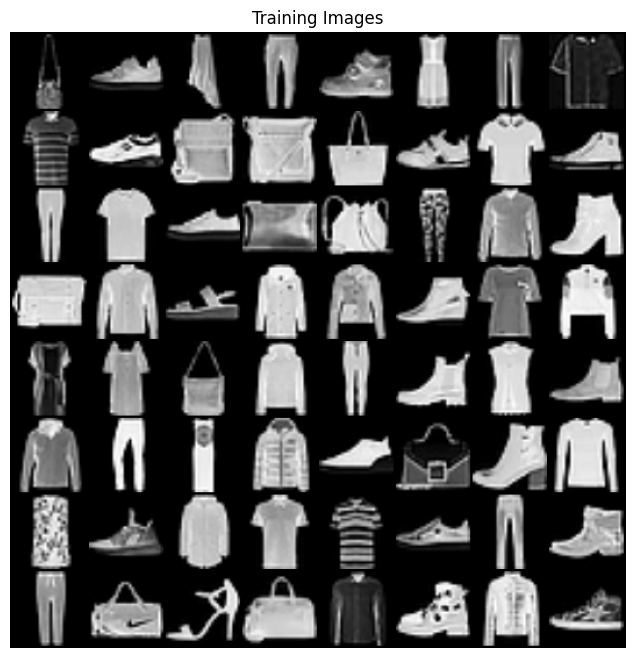

In [2]:
# Hyperparameters
dataroot = "./data/mnist"
workers = 2
batch_size = 128
image_size = 64  # Resizing Fashion-MNIST to 64x64 for standard DCGAN architecture
nz = 100         # Size of z latent vector (i.e. size of generator input)
ngf = 64         # Size of feature maps in generator
ndf = 64         # Size of feature maps in discriminator
num_epochs = 5   # Set higher for better results (e.g., 20+)
lr = 0.0002
beta1 = 0.5
nc = 1           # Number of channels (1 for grayscale)

# Data Pipeline
# We normalize to [-1, 1] to match the Tanh activation at the output of the Generator
dataset = dset.FashionMNIST(root=dataroot, train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Visualize a training batch
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## 4. Model Architecture (PyTorch)

### Weight Initialization
The DCGAN paper specifies that all model weights shall be randomly initialized from a Normal distribution with `mean=0` and `stdev=0.02`. This is distinct from the default PyTorch initialization.

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### The Generator
The Generator takes a latent noise vector $z$ and maps it to the data space via a series of strided transposed convolutions (deconvolutions), batch normalizations, and ReLU activations. The final layer uses a Tanh activation.

In [4]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### The Discriminator
The Discriminator is a strided convolutional network that downsamples the input image. It utilizes Leaky ReLU activations to prevent dead neurons.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the Generator
netG = Generator(0).to(device)
netG.apply(weights_init)
# print(netG) # Optional: print architecture

# Create the Discriminator
netD = Discriminator(0).to(device)
netD.apply(weights_init)
# print(netD) # Optional: print architecture

print("Models initialized and weights set.")

Models initialized and weights set.


## 5. Adversarial Training Loop (The Core)

We now define the loss function (Binary Cross Entropy) and the optimizers (Adam). We will track the loss of both $G$ and $D$ over the epochs.

**Key Step:** When training the Generator, we want to maximize $\log D(G(z))$. However, in practice, we minimize $\log(1 - D(G(z)))$ due to better gradient properties early in learning.

In [7]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.4377	Loss_G: 5.0211	D(x): 0.6497	D(G(z)): 0.5480 / 0.0107
[0/5][100/469]	Loss_D: 0.2989	Loss_G: 4.1493	D(x): 0.8877	D(G(z)): 0.1273 / 0.0231
[0/5][200/469]	Loss_D: 0.1384	Loss_G: 4.2288	D(x): 0.9224	D(G(z)): 0.0408 / 0.0271
[0/5][300/469]	Loss_D: 0.1613	Loss_G: 4.3888	D(x): 0.9476	D(G(z)): 0.0948 / 0.0222
[0/5][400/469]	Loss_D: 0.4201	Loss_G: 3.8725	D(x): 0.9210	D(G(z)): 0.2572 / 0.0350
[1/5][0/469]	Loss_D: 0.4329	Loss_G: 3.5353	D(x): 0.7150	D(G(z)): 0.0171 / 0.0634
[1/5][100/469]	Loss_D: 1.4346	Loss_G: 0.5204	D(x): 0.3481	D(G(z)): 0.0130 / 0.6622
[1/5][200/469]	Loss_D: 0.2519	Loss_G: 3.0511	D(x): 0.8650	D(G(z)): 0.0801 / 0.0671
[1/5][300/469]	Loss_D: 0.2646	Loss_G: 2.7395	D(x): 0.8595	D(G(z)): 0.0797 / 0.0972
[1/5][400/469]	Loss_D: 0.4936	Loss_G: 1.9758	D(x): 0.6825	D(G(z)): 0.0350 / 0.1846
[2/5][0/469]	Loss_D: 0.2392	Loss_G: 3.1822	D(x): 0.9228	D(G(z)): 0.1301 / 0.0608
[2/5][100/469]	Loss_D: 0.3917	Loss_G: 3.2475	D(x): 0.8159	D(G(z)): 

## 6. Results & Visualization

### Loss Curves
Analyzing the loss curves of GANs is non-trivial. Unlike classification where loss decreases monotonically, GAN loss oscillates. A stable equilibrium is often where the Generator loss stabilizes around a distinct value.

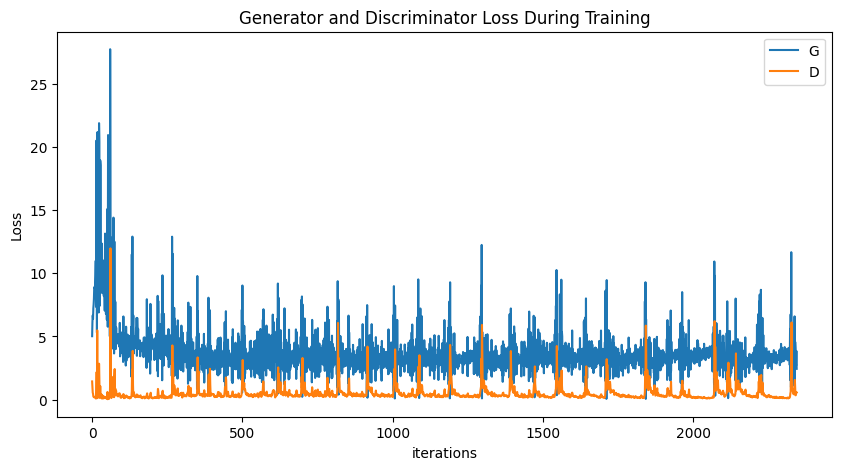

In [8]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Final Generated Gallery
Below we visualize the progression of the Generator. Notice how the network starts with random noise and gradually learns standard shapes.

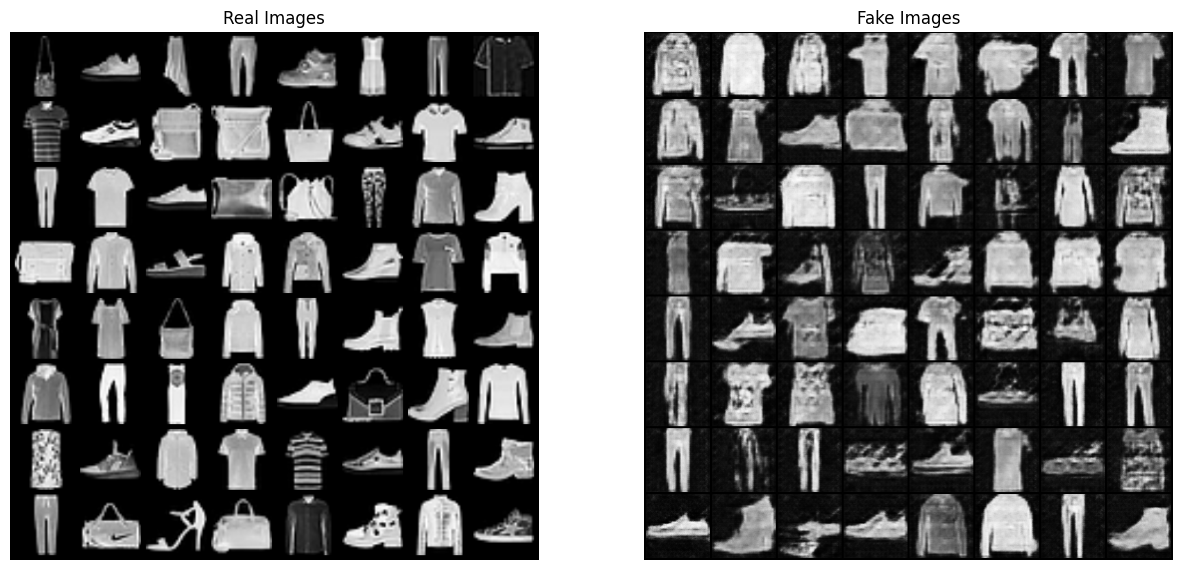

In [9]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## 7. Conclusion

### Summary
We have successfully trained a Deep Convolutional GAN (DCGAN) on the Fashion-MNIST dataset. The Generator learned to map random noise ($z$) to high-dimensional image space, producing synthetic fashion items that mimic the data distribution.

### Addressing Failure Modes
- **Mode Collapse**: This occurs when the Generator learns to map all $z$ vectors to the same output image. Our use of Batch Normalization and proper hyperparameter tuning (Learning Rate = 0.0002) mitigates this risk.

### Future Directions
While DCGANs are foundational, the field has evolved towards:
- **StyleGAN**: Disentangles the latent space for high-resolution control.
- **Diffusion Models (DDPM)**: The current state-of-the-art, which treats generation as an iterative denoising process rather than a one-shot adversarial game.